In [8]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [9]:
zip_path = "/workspaces/Demand-Forecasting-Project/data/archive.zip"
extract_path = "../data/"

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Data extracted successfully!")
else:
    print("archive.zip not found, skipping extraction.")

print("Data folder contents:", os.listdir(extract_path))

Data extracted successfully!
Data folder contents: ['Walmart.csv', 'archive.zip']


In [10]:
csv_path = "/workspaces/Demand-Forecasting-Project/data/Walmart.csv"
df = pd.read_csv(csv_path)

# Ensure Date column is datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Aggregate weekly sales across all stores
ts = df.groupby('Date')['Weekly_Sales'].sum().sort_index()
print("Time series head:")
print(ts.head())

Time series head:
Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
Name: Weekly_Sales, dtype: float64


In [11]:
train = ts[:-52]  # all but last year
test = ts[-52:]   # last year

In [12]:
# SARIMA Model

model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = model.fit()
print(sarima_result.summary())

/workspaces/Demand-Forecasting-Project/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/workspaces/Demand-Forecasting-Project/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/workspaces/Demand-Forecasting-Project/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/workspaces/Demand-Forecasting-Project/venv/lib/python3.12/site-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) *

                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                   91
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                   0.000
Date:                            Sat, 07 Feb 2026   AIC                             10.000
Time:                                    10:33:24   BIC                                nan
Sample:                                02-05-2010   HQIC                               nan
                                     - 10-28-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2392         -0       -inf      0.000       0.239       0.239
ma.L1         -0.7492         -0   

/workspaces/Demand-Forecasting-Project/venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:472: RuntimeWarning: Mean of empty slice
  xo = x - x.mean()
/workspaces/Demand-Forecasting-Project/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [13]:
# Forecast Next 52 Weeks
forecast = sarima_result.forecast(steps=52)

# Save forecast and test actual to CSV
forecast.to_csv('../data/forecast_sarima.csv', header=['Weekly_Sales'])
test.to_csv('../data/test_actual.csv')

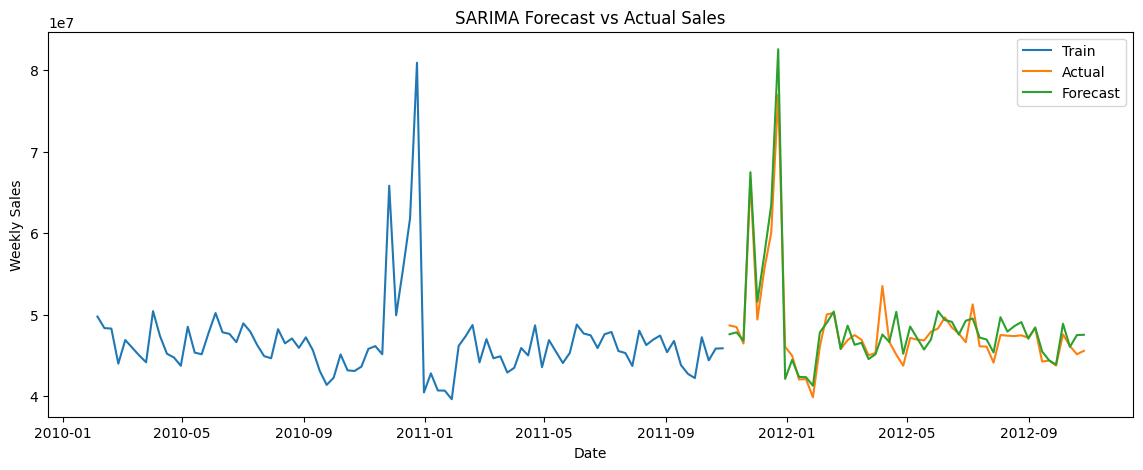

In [14]:
plt.figure(figsize=(14,5))
plt.plot(train, label='Train')
plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast')
plt.title("SARIMA Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

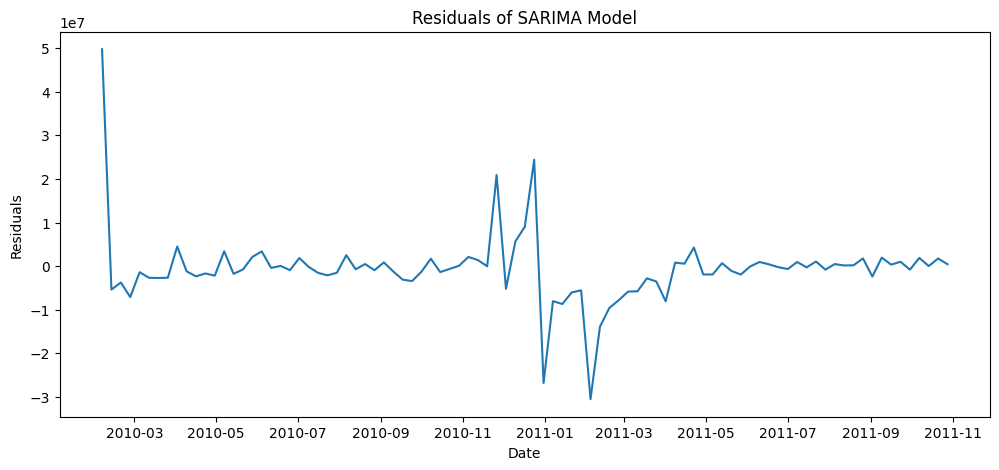

In [15]:
residuals = sarima_result.resid
plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.title("Residuals of SARIMA Model")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

In [16]:
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast) * 100
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 1912299.01
MAPE: 2.69%
